In [12]:
import openpyxl
import psutil
import os
import datetime
import time
import threading
import functools
import pandas as pd
import matplotlib.pyplot as plt
# xlrd, need to be installed

In [2]:
def singleton(class_):
    instances = {}
    def getinstance(*args, **kwargs):
        if class_ not in instances:
            instances[class_] = class_(*args, **kwargs)
        return instances[class_]
    return getinstance


def timeit(func):
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        value = func(*args, **kwargs)
        stop = time.perf_counter()
        print(f'\nHas been running for {round(stop-start, 2)} seconds.')
        return value
    return wrapper

In [3]:
@timeit
def do_something(seconds=1):
    print(f'Sleep for {seconds} seconds...')
    time.sleep(seconds)
    print(f'Done sleeping {seconds} seconds...')

do_something()

Sleep for 1 seconds...
Done sleeping 1 seconds...

Has been running for 1.01 seconds.


In [4]:
def do_something(seconds=1):
    print(f'Sleep for {seconds} seconds...')
    time.sleep(seconds)
    print(f'Done sleeping {seconds} seconds...')
    

@timeit
def run_threads():
    n = 4
    threads = [threading.Thread(target=do_something, args=(s,), kwargs=None) for s in range(n, 0, -1)]
    print(f'Running {len(threads)} threads.\n')
    
    for t in threads:
        t.start()
    
    for t in threads:
        t.join()

run_threads()

Running 4 threads.

Sleep for 4 seconds...
Sleep for 3 seconds...
Sleep for 2 seconds...
Sleep for 1 seconds...
Done sleeping 1 seconds...
Done sleeping 2 seconds...
Done sleeping 3 seconds...
Done sleeping 4 seconds...

Has been running for 4.01 seconds.


In [5]:
@singleton
class Excel():
    
    
    def __init__(self,):
        print('Singleton Class')
        self.file = False
        self.path = False
        
        
    def create(self, path):
        file = openpyxl.Workbook()
        file.save(path)
    
    
    def from_path(self, path):
        self.path = path
        self.file = openpyxl.load_workbook(path)
        self.sheet = self.file.active
        self.__assert_file__()
        
        
    def __assert_file__(self):
        assert self.file, "No excel file found... load excel file!"
        
        
    def create_columns_names(self, column_names):
        self.__assert_file__()
        XLSX_COLUMNS = list('abcdefghijklmnopqrstuvwxyz'.upper())
        sheet = self.file.active
        for idx, name in enumerate(column_names):
            sheet[f"{XLSX_COLUMNS[idx]}1"] = name
         
        
    def append_row(self, row):
        self.__assert_file__()
        self.sheet.append(row)
        
        
    def save(self):
        self.__assert_file__()
        self.file.save(self.path)
        

In [6]:
filename = 'CPU_performance.xlsx'
path = os.path.join(os.curdir, filename)
excel = Excel()

if filename not in os.listdir():
    excel.create(path)

excel.from_path(path)
print(f'Excel opened from path "{excel.path}".')

Singleton Class
Excel opened from path "./CPU_performance.xlsx".


In [7]:
n_cpu_logical = psutil.cpu_count(logical=True)
print(f'There is {n_cpu_logical} logical CPU(s) available.')

column_names = [f'CPU {idx+1}' for idx in range(n_cpu_logical)]
column_names.append('Datetime')

excel.create_columns_names(column_names)
excel.save()
print(f'Excel saved on path "{excel.path}".')

There is 16 logical CPU(s) available.
Excel saved on path "./CPU_performance.xlsx".


In [8]:
n_observations = 4

for _ in range(n_observations):
    date = datetime.datetime.now().strftime("%H:%M:%S %d/%m/%Y")
    perc = psutil.cpu_percent(interval=1, percpu=True)
    perc.append(date)
    excel.append_row(perc)
    print('appended row...')

excel.save()
print(f'Excel saved on path "{excel.path}".')

appended row...
appended row...
appended row...
appended row...
Excel saved on path "./CPU_performance.xlsx".


---

In [9]:
def cpu_performance(func):
    countdown = 2
        
    def measure_cpu_performance(event, excel):
        event.wait()
        print('Recording!')
        while event.is_set():
            date = datetime.datetime.now().strftime("%H:%M:%S %d/%m/%Y")
            perc = psutil.cpu_percent(interval=1, percpu=True)
            perc.append(date)
            excel.append_row(perc)
            print(f'*{date} appended row...')
        
    @functools.wraps(func)    
    def wrapper(*args, **kwargs):
        ######################################################
        # Load excel
        filename = 'CPU_performance.xlsx'
        path = os.path.join(os.curdir, filename)
        excel = Excel()

        if filename not in os.listdir():
            excel.create(path)

        excel.from_path(path)
        print(f'Excel opened from path "{excel.path}".')
        ######################################################
        # Set columns
        n_cpu_logical = psutil.cpu_count(logical=True)
        print(f'There is {n_cpu_logical} logical CPU(s) available.')

        column_names = [f'CPU {idx+1}' for idx in range(n_cpu_logical)]
        column_names.append('Datetime')

        excel.create_columns_names(column_names)
        excel.save()
        print(f'Excel saved on path "{excel.path}".')
        ######################################################
        # Run thread
        event = threading.Event()
        event.set()
        t = threading.Thread(target=measure_cpu_performance, name='thread_cpu_performance', kwargs={'event':event, 'excel':excel})
        t.start()
        time.sleep(3)
        
        #########
        #########
        print(func.__name__)
        value = func(*args, **kwargs)
        #########
        #########
        event.clear()
        print('Stop recording!')
        excel.save()
        
        
        time.sleep(2)
        
        return value
    return wrapper

In [10]:
@timeit
@cpu_performance
def do_something(seconds=1):
    print(f'Sleep for {seconds} seconds...')
    time.sleep(seconds)
    print(f'Done sleeping {seconds} seconds...')
    
do_something(4)

Excel opened from path "./CPU_performance.xlsx".
There is 16 logical CPU(s) available.
Excel saved on path "./CPU_performance.xlsx".
Recording!
*11:21:09 05/11/2020 appended row...
*11:21:10 05/11/2020 appended row...
do_something
Sleep for 4 seconds...
*11:21:11 05/11/2020 appended row...
*11:21:12 05/11/2020 appended row...
*11:21:13 05/11/2020 appended row...
*11:21:14 05/11/2020 appended row...
Done sleeping 4 seconds...
Stop recording!
*11:21:15 05/11/2020 appended row...

Has been running for 9.08 seconds.


[]

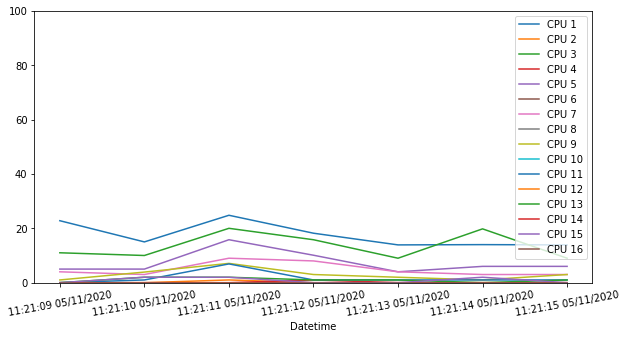

In [31]:
df = pd.read_excel(path, index_col='Datetime')
df.plot(kind='line', figsize=(10, 5), ylim=(0, 100))
plt.xticks(rotation=10)
plt.plot()

### Flask app

In [ ]:
from flask import Flask
app = Flask(__name__)


@app.route('/')
def hello():
    return "Hello World!"

app.run()

## 00 Initialization

---
#### a) Jupyter Notebook


In [ ]:
!jupyter kernelspec list

#### b) Check executable python path

In [ ]:
import sys

In [ ]:
print(sys.executable)

#### c) Where all dependencies are

In [4]:
for path in sys.path:
    print(path) 

/Users/patryklaskowski/Desktop/Computer_Vision
/Library/Frameworks/Python.framework/Versions/3.7/lib/python37.zip
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/lib-dynload

/Users/patryklaskowski/Desktop/Computer_Vision/env/lib/python3.7/site-packages
/Users/patryklaskowski/Desktop/Computer_Vision/env/lib/python3.7/site-packages/IPython/extensions
/Users/patryklaskowski/.ipython


I want to know
- how much of each cpu is used while running script,
- how much network is used while running script,
- how much memory is used while running script,

All of above i want to encapsulate in a single simple decorator.

---
#### Import libraries

In [7]:
import psutil
import time
import functools
import numpy as np
import matplotlib.pyplot as plt

#### Current cpu usage per cpu

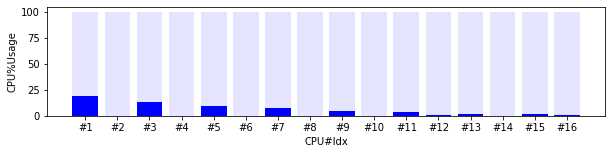

In [12]:
def plot_current_per_cpu_percent():
    perc = psutil.cpu_percent(interval=2, percpu=True)
    
    color = 'blue'
    x = range(1, len(perc)+1)
    tick_label = [f'#{i}' for i in x]

    plt.figure(figsize=(10, 2))
    plt.bar(x, np.zeros((len(perc)))+100, color=color, alpha=0.1, tick_label=tick_label)
    plt.bar(x, perc, color=color)
    plt.ylabel('CPU%Usage')
    plt.xlabel('CPU#Idx')
    plt.plot()

plot_current_per_cpu_percent()

In [16]:
from psutil._common import bytes2human


def pprint_ntuple(nt):
    for name in nt._fields:
        value = getattr(nt, name)
        if name != 'percent':
            value = bytes2human(value)
        print('%-10s : %7s' % (name.capitalize(), value))


def main():
    print('MEMORY\n------')
    pprint_ntuple(psutil.virtual_memory())
    print('\nSWAP\n----')
    pprint_ntuple(psutil.swap_memory())
    
main()

MEMORY
------
Total      :   16.0G
Available  :    5.7G
Percent    :    64.4
Used       :    8.1G
Free       :  429.1M
Active     :    5.3G
Inactive   :    5.0G
Wired      :    2.8G

SWAP
----
Total      :    2.0G
Used       :  884.5M
Free       :    1.1G
Percent    :    43.2
Sin        :  161.6G
Sout       :  485.9M


In [18]:
psutil.net_io_counters.cache_clear()
psutil.net_io_counters()

snetio(bytes_sent=4436720640, bytes_recv=77458838528, packets_sent=36904254, packets_recv=60860445, errin=0, errout=134685, dropin=0, dropout=0)

In [20]:
for idx, process in enumerate(psutil.process_iter()):
    if process.pid == os.getpid():
        print(process)

psutil.Process(pid=31535, name='Python', status='running', started='00:05:59')


---
#### Decorators

- [ ] timeit : mierzy czas, zwraca słownik 

In [36]:
def timeit(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        value = func(*args, **kwargs)
        stop = time.perf_counter()
        elapsed = round(stop - start, 2)
        print(f'Funcion "{func.__name__}({args, kwargs})" has been running for {elapsed} seconds.')
        return
    return wrapper

In [49]:
# @timeit
def do_something(seconds:int=0.5):
    print(f'Sleeping for {seconds} s.')
    time.sleep(seconds)
    print(f'Done sleeping for {seconds} s.')
    
do_something()

Sleeping for 0.5 s.
Done sleeping for 0.5 s.


#### CPU Count

In [56]:
n_cpu_physical = psutil.cpu_count(logical=False)
n_cpu_logical = psutil.cpu_count(logical=True)

print(f'There is {n_cpu_physical} physical CPU(s) available.')
print(f'There is {n_cpu_logical} logical CPU(s) available.')

There is 8 physical CPU(s) available.
There is 16 logical CPU(s) available.


---
#### CPU usage

In [33]:
def plot_timeseries(timeseries:list):
    plt.figure(figsize=(16, 4))

    n_time_intervals, n_cores = timeseries.shape
    x = list(range(n_time_intervals))

    for i in range(n_cores):
        plt.plot(x, timeseries[:, i], label=f'core {i+1}', marker='o')

    plt.ylim(0, 100)
    plt.yticks(range(0, 100+1, 10))
    plt.xticks(range(0, n_time_intervals, 1))
    plt.grid(axis='y')
    plt.legend()
    plt.plot()

In [35]:
interval = 1 #s
n = 5

@timeit
def cpu_percent(interval, n=5):
    timeseries = []
    for _ in range(n):
        timeseries.append(psutil.cpu_percent(interval, percpu=True))
    return np.array(timeseries)
        
        
timeseries = cpu_percent(interval, n)
print(f'\nTimeseries shape: {timeseries['value'].shape}')

plot_timeseries(timeseries)

SyntaxError: invalid syntax (<ipython-input-35-8f0f9eb21a34>, line 13)

In [59]:
def performance(func):

    @timeit
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        
#         start = time.perf_counter()
        
        value = func(*args, **kwargs)
        
#         stop = time.perf_counter()
#         print(f'Funcion "{func.__name__}({args, kwargs})" has been running for {round(stop - start, 2)} seconds.')
        
        return value
    return wrapper

In [61]:
@performance
def func():
    time.sleep(2)
    
func()

Funcion "func(((), {}))" has been running for 2.0 seconds.
